# Hyper parameter tuning best performing model + degree of granularity 


#### Justification of model choice

While comparison between linear, and binary models are difficult. The linear system did not have perfomance metrics which justidy its additional complexity, and arguablyt performed worse than binary metrics.

In addition, the nature of the final output lends its self better to a classification problem (low, medium, high risk) rather than exact quantities.

-- With no clear seperation between the three binary classification models. I am going to use XG_boost


#### Justification of granularity choice 

The data set which contains the highest level of granulity, while still preserving performance is the best model 

In addtion, the model which actually serves the final output goal 

-- Thus the combination of "Weekend split + 120 minute time bin" was chosen. It had high performance across all of the models and intuitively captures underlying passenger movement

## Hyperparameter tuning XGBoost

In [4]:
import optuna
from xgboost import XGBClassifier 
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, train_test_split
import pandas as pd 
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np

In [5]:
data = pd.read_csv("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/2_Granularity_tuning/Pipe2/Combo_120min_Weekendsplit_Final.csv")

data.drop(columns = ["Unnamed: 0"], inplace = True)
data["Risk_level"] = data["Unvalidated_mean"].map(lambda x : 1 if x > 2 else 0)

# spliting into X and y
X_all = data.drop(columns=["Unvalidated_mean", "Risk_level", "n_rows"])
y_all = data["Risk_level"]

 # Train-test split - final hold out test size of 0.15
X, X_test, y, y_test = train_test_split(X_all, y_all, test_size=0.15, random_state=42, stratify=y_all)


def objective(trial):
    params = {
        "n_estimators": 1500,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 50, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 50, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
        "min_split_loss": trial.suggest_float("min_split_loss", 0, 10),
        "n_jobs": -1,
        "random_state": 42
    }
    cross_val = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

    scores = []

    #performing cross validation
    # splitting into 5 folds. Training each fold on the same parameters, and reporting the mean AUC score 
    # I dont think I need a final testing set right? 
    for train_index, val_index in cross_val.split(X, y):
        X_train, X_valid = X.iloc[train_index].copy(), X.iloc[val_index].copy()
        y_train, y_valid = y.iloc[train_index], y.iloc[val_index]

        # scaling 
        num_cols = ["density", "Visiting_score", "Rel_Visiting_score", "Validation_Count_mean"]
        scaler = StandardScaler()
        X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
        X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # smote on training split 
        x_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)


        # init model
        model = XGBClassifier(**params)
        # train 
        model.fit(x_train_res, y_train_res)
        # test
        y_prob = model.predict_proba(X_valid)[:, 1]
        # append result
        score = roc_auc_score(y_valid, y_prob)
        scores.append(score)

    score = sum(scores) / 5
    return score
    

    
        
        
        
        

## XGBOOST + optuna with one hot encoded NIMI

In [6]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-11-30 18:36:17,654] A new study created in memory with name: no-name-03f8c2ac-56a8-44e1-b9ee-f146c34aa8cd
[I 2025-11-30 18:36:24,943] Trial 0 finished with value: 0.7210924135067495 and parameters: {'learning_rate': 0.03509269240735452, 'max_depth': 14, 'reg_lambda': 9.123287733361671, 'reg_alpha': 0.0034253240439782898, 'colsample_bytree': 0.7505333812785888, 'max_delta_step': 1, 'min_split_loss': 3.8676387760958955}. Best is trial 0 with value: 0.7210924135067495.
[I 2025-11-30 18:36:29,819] Trial 1 finished with value: 0.7167867309076159 and parameters: {'learning_rate': 0.04458260769120964, 'max_depth': 13, 'reg_lambda': 0.0033412313849559426, 'reg_alpha': 0.0402501965503721, 'colsample_bytree': 0.3352645742717575, 'max_delta_step': 10, 'min_split_loss': 4.002510362851326}. Best is trial 0 with value: 0.7210924135067495.
[I 2025-11-30 18:36:33,954] Trial 2 finished with value: 0.7163168098788683 and parameters: {'learning_rate': 0.14492135749906743, 'max_depth': 10, 'reg_la

In [7]:
print("Best trial:", study.best_trial.params)
print("Best ROC-AUC:", study.best_value)

Best trial: {'learning_rate': 0.00149861304965371, 'max_depth': 20, 'reg_lambda': 28.48527796632275, 'reg_alpha': 0.001156724393799165, 'colsample_bytree': 0.7633381370584973, 'max_delta_step': 10, 'min_split_loss': 1.018433605352791}
Best ROC-AUC: 0.7219978245480444


In [8]:
# Testing on final hold out testing set
params = study.best_trial.params
model = XGBClassifier(**params)
model.fit(X, y)
y_prob = model.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_prob)

0.7061793725034994

### Plotting ROC curve for the best model

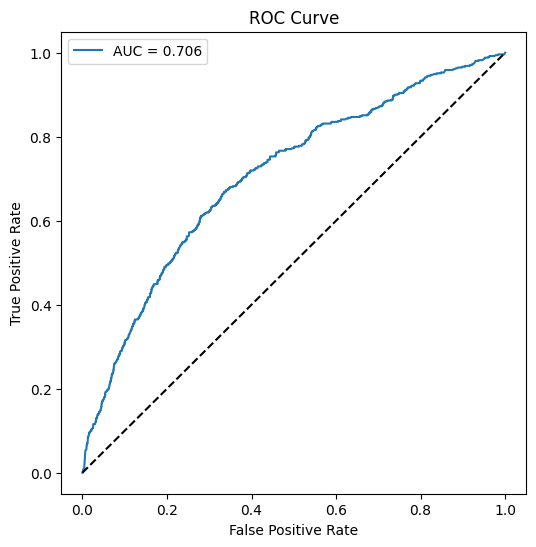

Best threshold: 0.128
TPR at best threshold: 0.669
FPR at best threshold: 0.335


In [9]:
def plot_roc_curve_and_best_threshold(y_true, y_prob):
    # Compute ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    
    # Plot ROC curve
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_true, y_prob):.3f}')
    plt.plot([0,1], [0,1], 'k--')  # random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    
    plt.savefig(f"c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/3_ML_performance/Pipe2/XGBoost_tuned_ROC.svg", format='svg', bbox_inches='tight')
    
    plt.show()
    
    # Compute Youden's J statistic
    J = tpr - fpr
    idx = np.argmax(J)
    best_threshold = thresholds[idx]
    
    print(f"Best threshold: {best_threshold:.3f}")
    print(f"TPR at best threshold: {tpr[idx]:.3f}")
    print(f"FPR at best threshold: {fpr[idx]:.3f}")
    
    return best_threshold

best_thresh = plot_roc_curve_and_best_threshold(y_test, y_prob)


## Exporting

In [12]:
# Saving the model
model.save_model("C:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/4_Hyperparam_tuning_XGBoost/Pipe1/xgb_model.json")


In [2]:
import pandas as pd
data = pd.read_csv("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/2_Granularity_tuning/Pipe2/Combo_120min_Weekendsplit_Final.csv")

data.drop(columns = ["Unnamed: 0"], inplace = True)
data["Risk_level"] = data["Unvalidated_mean"].map(lambda x : 1 if x > 2 else 0)


In [4]:
data.drop(columns = ["Unvalidated_mean", "Risk_level", "n_rows", "Risk_level"]).columns

Index(['Pre_2019', 'Validation_Count_mean', 'Visiting_score',
       'Rel_Visiting_score', 'density', 'time_sin', 'time_cos',
       'NIMI_Annelinna', 'NIMI_Ihaste', 'NIMI_Jaamamõisa', 'NIMI_Karlova',
       'NIMI_Kesklinna', 'NIMI_Kvissentali', 'NIMI_Maarjamõisa',
       'NIMI_Raadi-Kruusamäe', 'NIMI_Ropka', 'NIMI_Ropka tööstuse',
       'NIMI_Ränilinna', 'NIMI_Supilinna', 'NIMI_Tammelinna', 'NIMI_Tähtvere',
       'NIMI_Vaksali', 'NIMI_Variku', 'NIMI_Veeriku', 'NIMI_Ülejõe',
       'Binned_day_0', 'Binned_day_1'],
      dtype='object')